In this notebook, we extract significantly spatially varying genes in cell type specific AOIs.

Load relevant packages, including SpatialDE:

In [1]:
import sys,os
path = '/nfs/team283/aa16/InSituCellTools/'
os.chdir(path)
sys.path.append(path)

In [2]:
%pylab inline
import pandas as pd
import NaiveDE
import SpatialDE
import statsmodels.stats.multitest as multi
import scipy.stats as ss
import pickle as pickle
import scipy as sc

Populating the interactive namespace from numpy and matplotlib


Load the data and remove negative probes for this analysis:

In [3]:
adata = pickle.load(open('data/nanostringWTA_fetailBrain_AnnData.p',  "rb"))
adata = adata[:,adata.var_names != 'NegProbe-WTX']

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


Choose the data from 19pcw replicates, in cell type specific AOIs at radial position 1,3:

In [4]:
subset_19pcw = list()
for j in range(2):
    subset_19pcw.append([adata.obs['Radial_position'][i] in (1,3) and
                    adata.obs['AOI_type'][i] == ('HOPXpos', 'EOMESpos')[j] and
                    adata.obs['age'][i] == '19pcw' for i in range(np.shape(adata.obs)[0])])

Prepare data for spatialDE:

In [5]:
adata.layers['Stabilized'] = NaiveDE.stabilize(adata.X)
adata.obs['TotalCounts'] = np.sum(adata.X, axis = 1)
adata.layers['TotalCountsRegressed'] = NaiveDE.regress_out(adata.obs, adata.layers['Stabilized'].T, 'np.log(TotalCounts)').T
adata.layers['CPM'] = np.asarray([adata.X[i,:]/adata.obs['TotalCounts'][i] for i in range(len(adata.obs['TotalCounts']))])*10**6
adata.layers['zscore_19pcw'] = sc.stats.zscore(np.log2(adata.layers['CPM']+1), axis = 0)

Run spatialDE (only on genes detected in at least 5 ROIs):

In [6]:
detected = list()
for j in range(2):
    print(j)
    detected.append([[adata.X[subset_19pcw[j],i][x] > adata.obs['GeoLOD2.5_01'][subset_19pcw[j]][x] 
     for i in range(np.shape(adata.X)[1])]
     for x in range(sum(subset_19pcw[j]))])

0
1


In [7]:
keep_genes = list()
for j in range(2):
    keep_genes.append(np.sum(detected[j], axis = 0) > 2)

In [8]:
input_data = list()
input_coordinates = list()
results = list()
for j in range(2):
    print(j)
    input_data.append(pd.DataFrame(adata.layers['TotalCountsRegressed'][subset_19pcw[j],:][:,keep_genes[j]], index = adata.obs['Sanger_sampleID'][subset_19pcw[j]],
                       columns = adata.var_names[keep_genes[j]]))
    input_coordinates.append(adata.obs.loc[subset_19pcw[j],('Radial_position', 'VCDepth')].rename(columns={"Radial_position": "x", "VCDepth": "y"}))
    results.append(SpatialDE.run(input_coordinates[j], input_data[j]))

0



1


Now remove all spatially varying genes that are also spatially varying in reference rings and higher expressed in reference rings in > 50% of regions.

Get list of all spatially varying genes:

In [9]:
for j in range(2):
    print(j)
    threshold = 0.05
    print('significance threshold (fdr/qval):', threshold)
    results[j] = results[j].sort_values('pval')
    genes_ranked = np.array(results[j]['g'])
    genes_significant_fdr = genes_ranked[multi.multipletests(results[j]['pval'], method = 'fdr_bh')[1] < threshold]
    genes_significant_qval = genes_ranked[results[j]['qval'] < 0.05]
    genes_significant_pval = genes_ranked[results[j]['pval'] < 0.05]
    print('genes significant (pval):', len(genes_significant_pval))
    print('genes significant (fdr):', len(genes_significant_fdr))
    print('genes significant (qval):', len(genes_significant_qval))
    overlap = sum([genes_significant_fdr[i] in genes_significant_qval for i in range(len(genes_significant_fdr))])/len(genes_significant_fdr)
    print('overlap_fdr_qval:', overlap)
    percent_significant_fdr = len(genes_significant_fdr)/len(genes_ranked)
    percent_significant_qval = len(genes_significant_qval)/len(genes_ranked)
    percent_significant_pval = len(genes_significant_pval)/len(genes_ranked)
    print('percent_significant_qval:', percent_significant_qval)
    print('percent_significant_fdr:', percent_significant_fdr)
    print('percent_significant_pval:', percent_significant_pval)

0
significance threshold (fdr/qval): 0.05
genes significant (pval): 400
genes significant (fdr): 0
genes significant (qval): 0
overlap_fdr_qval: nan
percent_significant_qval: 0.0
percent_significant_fdr: 0.0
percent_significant_pval: 0.06457862447529868
1
significance threshold (fdr/qval): 0.05
genes significant (pval): 382
genes significant (fdr): 0
genes significant (qval): 0
overlap_fdr_qval: nan
percent_significant_qval: 0.0
percent_significant_fdr: 0.0
percent_significant_pval: 0.06822646901232363


/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [10]:
results[0]

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
5755,8.766174e-01,4,CRH,0.153225,1.034869e-01,-16.212524,-8.071162,1.282877e+01,SE,20,0.002824,2.182603e-01,0.000709,44.407978,-30.035838,13.823314,0.000201,0.909457
4959,9.988959e-01,4,ZGLP1,0.017224,1.047025e-03,4.829266,-10.492837,5.782062e+01,SE,20,0.000002,1.291963e+00,0.000981,2.324398,-6.764108,11.593373,0.000662,0.909457
5974,9.085880e-01,4,PAQR8,0.153225,7.397377e-02,-1.446485,-8.765102,1.438106e+01,SE,20,0.002472,3.083703e-01,0.000549,14.875899,-12.159596,10.713112,0.001064,0.909457
5838,8.595519e-01,4,H1-5,0.153225,1.201394e-01,-2.682387,-6.701099,8.319062e+00,SE,20,0.004826,3.067945e-01,0.000758,17.347703,-13.088361,10.405974,0.001256,0.909457
6010,8.894919e-01,4,PNRC1,0.153225,9.134688e-02,-0.419480,-9.140696,1.543050e+01,SE,20,0.004083,3.747627e-01,0.000753,12.821890,-10.648000,10.228520,0.001383,0.909457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,2.039574e-09,4,KLHL8,0.001936,4.851652e+08,-18.317715,-10.297761,2.193264e-07,SE,20,0.033267,5.790381e+15,0.000959,48.618360,-18.330648,0.012933,0.909457,0.909457
3232,2.039574e-09,4,"RPL17-C18orf32,C18orf32",0.001936,4.851652e+08,2.008353,-10.457115,2.254884e-07,SE,20,0.028228,4.913361e+15,0.001238,7.966223,1.995420,0.012933,0.909457,0.909457
1604,2.048816e-09,4,TLK1,0.000218,4.851652e+08,-5.936563,-9.212670,1.751554e-07,SE,20,0.026779,4.619164e+15,0.001148,23.856055,-5.949496,0.012933,0.909457,0.909457
1456,2.048816e-09,4,SMIM15,0.000218,4.851652e+08,-1.486517,-9.007015,1.673538e-07,SE,20,0.025031,4.317583e+15,0.001298,14.955964,-1.499450,0.012933,0.909457,0.909457


In [62]:
pickle.dump(results, open( "../KR_NAS/data/spatialDE_results_AOIs.p", "wb" ))

In [8]:
results = pickle.load(open('../KR_NAS/data/spatialDE_results_AOIs.p', "rb"))

In [12]:
results[1].iloc[np.where(results[1]['g'] == 'MKI67')[0][0],]

FSV               0.727233
M                        4
g                    MKI67
l                 0.153225
max_delta         0.275778
max_ll            -4.64685
max_mu_hat         -8.5607
max_s2_t_hat       12.7407
model                   SE
n                       20
s2_FSV           0.0206648
s2_logdelta       0.561765
time            0.00069952
BIC                21.2766
max_ll_null       -10.4371
LLR                5.79021
pval             0.0161157
qval              0.586233
Name: 5028, dtype: object

In [26]:
input_data = []
for j in range(2):
    print(j)
    input_data.append(pd.DataFrame(adata.layers['CPM'][subset_19pcw[j],:][:,keep_genes[j]], index = adata.obs['Sanger_sampleID'][subset_19pcw[j]],
                       columns = adata.var_names[keep_genes[j]]))

0
1


Text(0, 0.5, 'CPM')

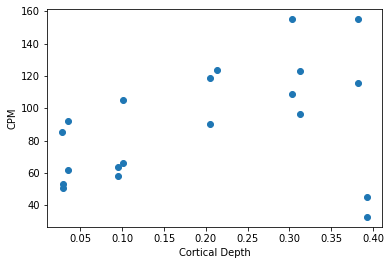

In [31]:
plt.scatter(input_coordinates[0]['y'], input_data[1]['MKI67'])
plt.xlabel('Cortical Depth')
plt.ylabel('CPM')